# Optimize Throw

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/optim/Learn_Throwing.ipynb)

This example uses automatic differentiation to find the optimal initial velocity in order to hit a target location.

There is a related demo that trains neural networks to learn this task.

In [2]:
%pip install --quiet phiflow
from phi.torch.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.

Let's write a function that computes the hit position given the initial position, velocity and angle of attack.

In [36]:
def simulate_hit(pos, height, vel, angle, gravity=1.):
    vel_x, vel_y = math.cos(angle) * vel, math.sin(angle) * vel
    height = math.maximum(height, .01)
    hit_time = (vel_y + math.sqrt(vel_y**2 + 2 * gravity * height)) / gravity
    return pos + vel_x * hit_time, hit_time, height, vel_x, vel_y

f"Starting at x=10, height=1 with velocity=1, angle=0 -> hit at x={simulate_hit(10, 1, 1, 0)[0]:no-color}"

'Starting at x=10, height=1 with velocity=1, angle=0 -> hit at x=11.414213'

To plot the trajectories, we define `sample_trajectory`.

In [4]:
def sample_trajectory(pos, height, vel, angle, gravity=1., steps=spatial(time=100)):
    _, hit_time, height, vel_x, vel_y = simulate_hit(pos, height, vel, angle, gravity)
    t = math.linspace(0, hit_time, steps)
    return vec(x=pos + vel_x * t, y=height + vel_y * t - gravity / 2 * t ** 2)

angles = vec('angle', -1, -.5, 0, .5, 1, 1.5)
trj = sample_trajectory(10, 1, 1, angles)
plot(trj.time.rename('const'), trj, title="Varying Angle", animate='time', overlay='args', color=math.range(angles.shape), frame_time=40)

Let's perform a classical optimization using gradient descent in the initial velocity `vel`. We need to define a loss function to optimize and get its derivative.

In [6]:
@jit_compile
def loss_function(pos, height, vel, angle, target):
  return math.l2_loss(simulate_hit(pos, height, vel, angle)[0] - target)

grad_fun = math.gradient(loss_function, wrt='vel', get_output=False)

Next, we define the gradient descent step and optimize for the velocity while keeping the other arguments fixed.

In [26]:
def gradient_descent_step(vel, pos, height, angle, target, step_size=.1):
    return vel - step_size * grad_fun(pos, height, vel, angle, target)

fixed = dict(pos=0, height=1, angle=0)
vel_trj = iterate(gradient_descent_step, batch(iter=25), 1., target=10, **fixed)

c:\phd\phiflow2\phiml\phiml\math\_functional.py:600: RuntimeWarning: Using torch for gradient computation because numpy does not support jacobian()
  warnings.warn(f"Using {math.default_backend()} for gradient computation because {key.backend} does not support jacobian()", RuntimeWarning)


Now we can plot how `vel` changes during the optimization.

<Figure size 216x216 with 1 Axes>

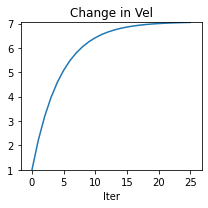

In [27]:
plot(vel_trj.iter.as_spatial(), size=(3, 3), title="Change in Vel")

Let's visualize the corresponding trajectories!

In [30]:
trj = sample_trajectory(vel=vel_trj, **fixed)
plot(trj, vec(x=10, y=0), overlay='args', animate='iter', title="Ball trajectory and target", size=(9, 2))

c:\phd\phiflow2\phi\vis\_vis_base.py:507: UserWarning: bounds argument is deprecated since 2.5 and will be ignored.
  return PointCloud(math.expand(obj, instance(points=1)), bounds=Cuboid(obj, half_size=math.const_vec(1e-3, obj.shape['vector'])).box())
